In [2]:
import pandas as pd
import numpy as np
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt

In [10]:
import rasterio
from rasterio.plot import show
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import Point
import os
import re
import matplotlib as plt


In [5]:
print("GeoPandas:", gpd.__version__)
print("Rasterio:", rasterio.__version__)

GeoPandas: 1.0.1
Rasterio: 1.4.3


In [9]:
import pyproj
from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    ChannelProfiler,
)

In [7]:
import landlab
print("Landlab está instalado correctamente.")

Landlab está instalado correctamente.


In [20]:
import rasterio as ras
from rasterio.plot import show

In [30]:
pend= ras.open( r"C:/Users/ximen/Desktop/UNAL/PRIMER SEMESTRE/SIG/IMAGENES/lansat_2014_ZN.tif")

pend


<open DatasetReader name='C:/Users/ximen/Desktop/UNAL/PRIMER SEMESTRE/SIG/IMAGENES/lansat_2014_ZN.tif' mode='r'>

In [120]:
pend.bounds

BoundingBox(left=-74.2535735754503, bottom=3.8955442295843055, right=-72.92792971067513, top=4.962742787118297)

In [118]:
pend.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 4919,
 'height': 3960,
 'count': 3,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.00026949458523585647, 0.0, -74.2535735754503,
        0.0, -0.00026949458523585647, 4.962742787118297)}

El área de estudio corresponde a cinco subzonas hidrografías aledaña y de influencia directa al PNN Chingaza y aca se utiliza el DEM.

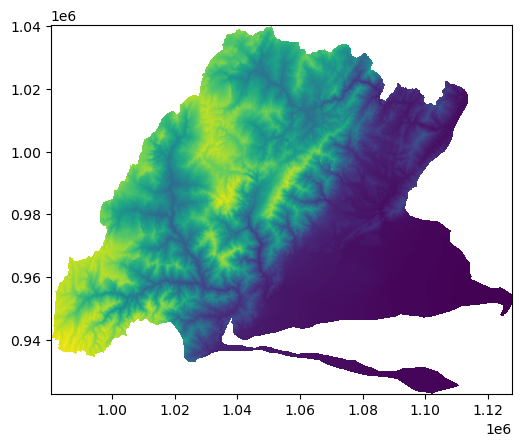

<Axes: >

In [11]:
# Open raster image 
rasterObj = rasterio.open("C:/Users/ximen/Desktop/UNAL/PRIMER SEMESTRE/SIG/PROYECTO/DEM/col_12m")

show(rasterObj)

Forma del array: (9828, 12263)
Valores mínimos y máximos: -32768 4115


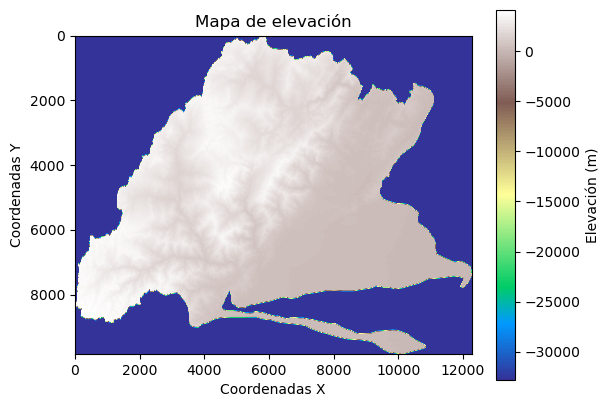

In [14]:
import rasterio
import matplotlib.pyplot as plt

# Cargar el raster
raster_path = "C:/Users/ximen/Desktop/UNAL/PRIMER SEMESTRE/SIG/PROYECTO/DEM/col_12m"
with rasterio.open(raster_path) as rasterObj:
    elevArray = rasterObj.read(1)  # Leer la primera banda del raster

# Se verifican los datos del array
print("Forma del array:", elevArray.shape)
print("Valores mínimos y máximos:", elevArray.min(), elevArray.max())

# Visualizar el array con imshow
plt.imshow(elevArray, cmap="terrain")  # Usar un colormap adecuado para datos de elevación
plt.colorbar(label="Elevación (m)")
plt.title("Mapa de elevación")
plt.xlabel("Coordenadas X")
plt.ylabel("Coordenadas Y")
plt.show()


In [36]:
#show array values (matriz en 2D)

elevArray

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

UTM: raster en x o y, no es la misma, por ende se realiza la operacion con landlab

In [18]:
#create grid from raster attributes
nrows = rasterObj.height  # number of raster cells on each side, initially 150
ncols = rasterObj.width
dxy = (rasterObj.transform.a,-rasterObj.transform.e)  # side length of a raster model cell, or resolution [m], initially 50

# define a landlab raster
mg = RasterModelGrid(shape=(nrows, ncols), 
                     xy_spacing=dxy,
                     xy_of_lower_left=(rasterObj.bounds[0],rasterObj.bounds[1]))

# show number of rows, cols and resolution
print(nrows, ncols, dxy)

In [36]:
from landlab import RasterModelGrid

# Parámetros de la rejilla
nrows = 50  # Número de filas
ncols = 50  # Número de columnas
dxy = 10.0  # Espaciado de celdas (en metros)

# Crear el modelo de rejilla
mg = RasterModelGrid((nrows, ncols), dxy)

# Crear un atributo de elevación inicializado en ceros
zr = mg.add_zeros("topographic__elevation", at="node")

# Mostrar información básica de la rejilla
print("Número de nodos:", mg.number_of_nodes)
print("Forma de la rejilla:", mg.shape)
print("Elevación inicial (primeros 10 nodos):", zr[:10])


Número de nodos: 2500
Forma de la rejilla: (50, 50)
Elevación inicial (primeros 10 nodos): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
# Verificar que las dimensiones de elevArray coincidan con (nrows, ncols)
print("Forma de elevArray:", elevArray.shape)
print("Forma de la rejilla:", (nrows, ncols))

# Asignar elevaciones desde el array (ajustar si elevArray está volteado)
zr += elevArray[::-1, :].ravel()  # Ravel convierte a 1D para asignarlo a nodos


Forma de elevArray: (9828, 12263)
Forma de la rejilla: (50, 50)


ValueError: operands could not be broadcast together with shapes (2500,) (120520764,) (2500,) 

In [48]:
from landlab.components import FlowAccumulator

In [50]:
# Acumulación de flujo
fa = FlowAccumulator(mg, flow_director="D4")  # D4 es la dirección del flujo
fa.run_one_step()  # Ejecutar un paso del acumulador de flujo

# Verificar los resultados
print("Flujo acumulado (primeros 10 nodos):")
print(mg.at_node["drainage_area"][:10])  # Área de drenaje calculada

Flujo acumulado (primeros 10 nodos):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, DepressionFinderAndRouter

# Crear un modelo de rejilla
nrows = 50  # Número de filas
ncols = 50  # Número de columnas
dxy = 10.0  # Espaciado entre nodos (metros)
mg = RasterModelGrid((nrows, ncols), dxy)

# Crear un campo de elevación inicial
elev = mg.add_zeros("topographic__elevation", at="node")
elev += mg.node_x + mg.node_y  # Generar un gradiente simple

# Acumulación de flujo
fa = FlowAccumulator(mg, flow_director="D4")
fa.run_one_step()

# Rellenar depresiones
df = DepressionFinderAndRouter(mg)
df.map_depressions()

# Verificar los resultados
print("Depresiones mapeadas (primeros 10 nodos):")
print(mg.at_node["depression__depth"][:10])  # Muestra la profundidad de las depresiones


Depresiones mapeadas (primeros 10 nodos):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


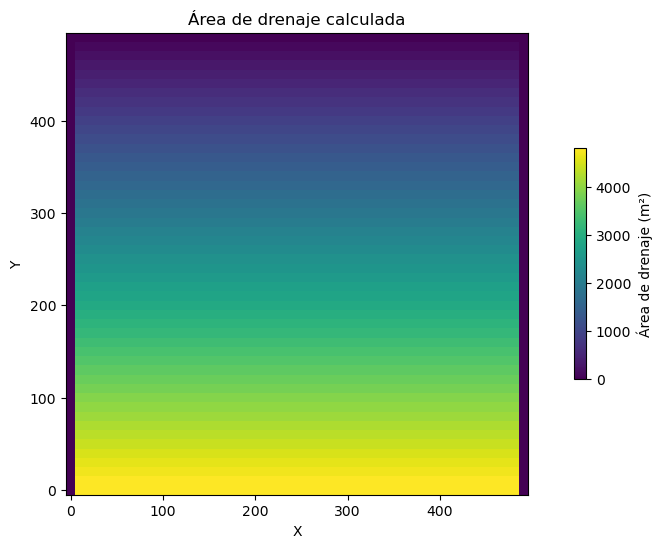

In [60]:
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.plot import imshow_grid  # Importar imshow_grid para visualización
import matplotlib.pyplot as plt

# Crear un modelo de rejilla
nrows = 50
ncols = 50
dxy = 10.0
mg = RasterModelGrid((nrows, ncols), dxy)

# Crear un campo de elevación inicial
elev = mg.add_zeros("topographic__elevation", at="node")
elev += mg.node_x + mg.node_y  # Gradiente simple

# Acumulación de flujo
fa = FlowAccumulator(mg, flow_director="D4")
fa.run_one_step()

# Visualizar el área de drenaje calculada
fig = plt.figure(figsize=(12, 6))
imshow_grid(mg, "drainage_area", shrink=0.5, cmap="viridis", colorbar_label="Área de drenaje (m²)")
plt.title("Área de drenaje calculada")
plt.show()


Exportan las cuencas que se quieren 

In [64]:
from landlab.components import ChannelProfiler

In [78]:
#profile the channel networks
profiler = ChannelProfiler(
    mg,
    number_of_watersheds=5,
    minimum_channel_threshold=1000000,
    main_channel_only=False)

#run profiler
profiler.run_one_step()

ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [4800. 4800. 4800. 4800. 4800.]

In [ ]:
#extract profile dict
profDict = profiler.data_structure
#create a geopandas dataframe to store the channel network
multiLineList = []
multiLineIndex = []

In [ ]:
#export geodataframe to shapefile
gdf.to_file('C:/Users/ximen/Desktop/UNAL/PRIMER SEMESTRE/SIG/IMAGENES/Imagen.shp')
#plot raster with stream networks
fig,ax = plt.subplots(figsize=(8,8))
show(rasterObj, ax=ax, cmap='GnBu')
gdf.plot(ax=ax, color='crimson')